In [140]:
# Libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

Init disordered Network Topology and Electrostatic Properties:
- Number of nanopartciles $N_{NP}$ and number of junctions per $N_{J}$
- Electrode Positions as list of cartesian coordinates `[[x_1, y_1], [x_2, y_2], [x_3, y_3], ...]` \
Network is placed inside box of size 1 with electrodes attached to closest nanoparticle

In [141]:
# Network Style
network_topology = "random"

# Network Parameter
topology_parameter  = {
    "Np"    : 49,
    "Nj"    : 4,
    "e_pos" : [[-1,-1],[1,1]]
}

# Save Folder
folder  = "test_runs/"

# Topology Class
np_network_sim = nanonets.simulation(network_topology=network_topology, folder=folder, topology_parameter=topology_parameter)

Display Network Topology

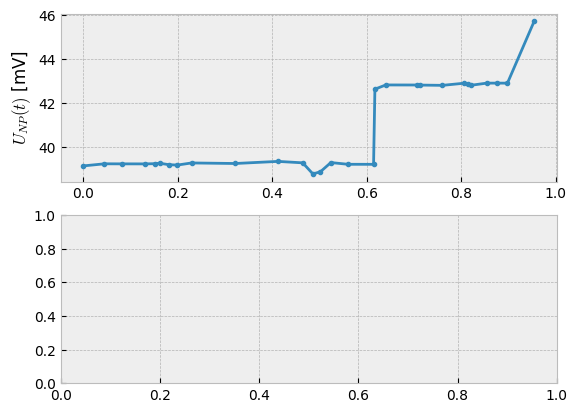

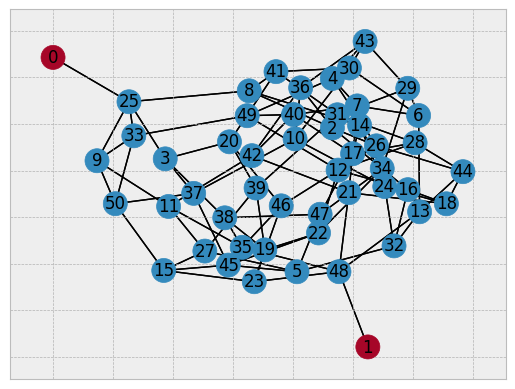

In [142]:
# Node Positions
fixed_pos                               = {i : val for i, val in enumerate(topology_parameter["e_pos"])}
pos                                     = nx.spring_layout(G=np_network_sim.G, pos=fixed_pos, fixed=[i for i in range(np_network_sim.N_electrodes)])
pos_vals                                = np.array(list(dict(sorted(pos.items())).values()))
pos_vals_e                              = pos_vals[np_network_sim.N_electrodes:]
pos_vals_e                              = 1.6*(pos_vals_e - np.min(pos_vals_e,axis=0))/(np.max(pos_vals_e,axis=0) - np.min(pos_vals_e,axis=0)) - 0.8
pos_vals[np_network_sim.N_electrodes:]  = pos_vals_e

for i in range(np_network_sim.N_particles):
    pos[i] = pos_vals[i,:]

# Node Colors
colors                                  = np.repeat('#348ABD', np_network_sim.N_particles+np_network_sim.N_electrodes)
colors[-np_network_sim.N_electrodes:]   = '#A60628'

# Display Graph
with plt.style.context(["bmh"]):

    fig = plt.figure()
    ax  = fig.add_subplot()
    nx.draw_networkx(G=np_network_sim.G, ax=ax, node_color=colors, arrows=False)
    plt.show()



Input Voltages

Number of Steps: 100000


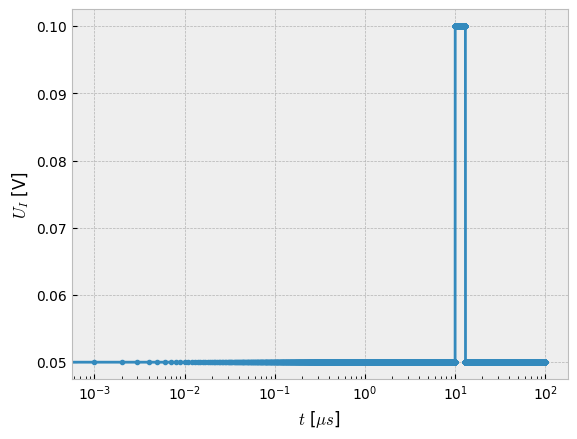

In [143]:
# Define Time Scale
step_size   = 1e-9
max_time    = 1e-4
time_steps  = np.arange(0,max_time,step_size)
N_steps     = len(time_steps)
print(f"Number of Steps: {N_steps}")

# Define Peak
t_min_peak      = 10e-6
t_max_peak      = 13e-6
peak_bounds     = (time_steps >= t_min_peak) & (time_steps <= t_max_peak)

# Input Voltages
input_volt                  = np.repeat(0.05,N_steps)
input_volt[peak_bounds]     = 0.1

# Voltage Array
voltages        = np.zeros((N_steps, np_network_sim.N_electrodes+1))
voltages        = np.zeros((N_steps, np_network_sim.N_electrodes+1))
voltages[:,0]   = input_volt
# voltages[:,1]   = np.repeat(-0.1, N_steps)
# voltages[:,2]   = np.repeat(0.3, N_steps)

# Plot
with plt.style.context("bmh"):
    
    plt.plot(time_steps*10**6, input_volt, '.-')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$U_I$ [V]")
    plt.xscale('log')
    plt.show()

Schrittweite verringern und statistics

In [144]:
store_per_it_min, store_per_it_max = 12e-6, 14e-6 #0,0
np_network_sim = nanonets.simulation(network_topology=network_topology, folder=folder, topology_parameter=topology_parameter)
np_network_sim.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=(np_network_sim.N_electrodes-1), save_th=.1,
                                store_per_it_min=store_per_it_min, store_per_it_max=store_per_it_max, R=25, Rstd=10)

In [145]:
start_val   = 100

# Return Output Current
output_vals = np_network_sim.return_output_values()
output_I    = output_vals[:,2]/1000
output_I    = output_I[start_val:]

# Return Microstate
microstate  = np_network_sim.return_microstates()
microstate  = microstate[start_val:]

# Return Landscape
landscape   = np_network_sim.return_potential_landscape()
landscape   = landscape[start_val:]

# Return Network Currents
jump_paths, network_I   = np_network_sim.return_network_currents()
network_I               = network_I[start_val:]

# Return Network Currents
pot_per_it = np_network_sim.return_pot_per_it()

# Return Jumps per Iteration
jumps_per_it = np_network_sim.return_jumps_per_it()

# Return inner Time Evolution
time_per_it     = np_network_sim.return_time_vals()
stored_indices  = np.where((time_steps >= store_per_it_min) & (time_steps < store_per_it_max))[0]

In [146]:
print(f"Average Jumps per Step: {np.round(np.mean(output_vals[:,1]),2)}")

Average Jumps per Step: 7.5


### Output electric Current

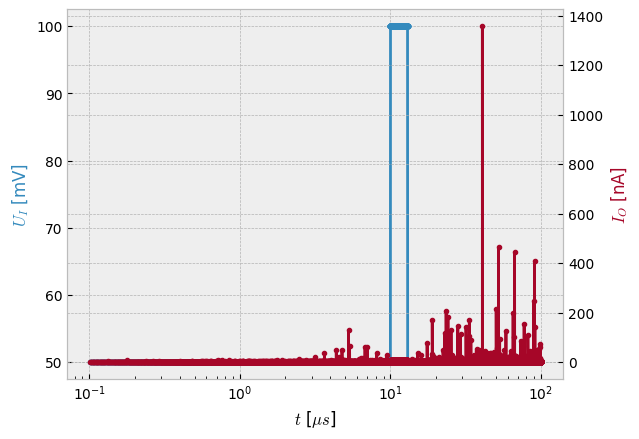

In [147]:
with plt.style.context("bmh"):
    
    fig = plt.figure()
    ax  = fig.add_subplot()
    ax2 = ax.twinx()
    ax.plot(time_steps[start_val+1:]*10**6, 1000*input_volt[start_val+1:], '.-', label='Input', c=blue_color)
    ax2.plot(time_steps[start_val+1:]*10**6, output_I, '.-', label='Output', c=red_color)
    # plt.xlim(0.8*t_min_peak*10**6, 1.2*t_max_peak*10**6)
    ax.set_xlabel("$t$ [$\mu s$]")
    ax.set_ylabel("$U_I$ [mV]", c=blue_color)
    ax2.set_ylabel("$I_O$ [nA]", c=red_color)
    ax.set_xscale('log')
    # ax.set_xlim(12,14)
    plt.show()

#### Micro State

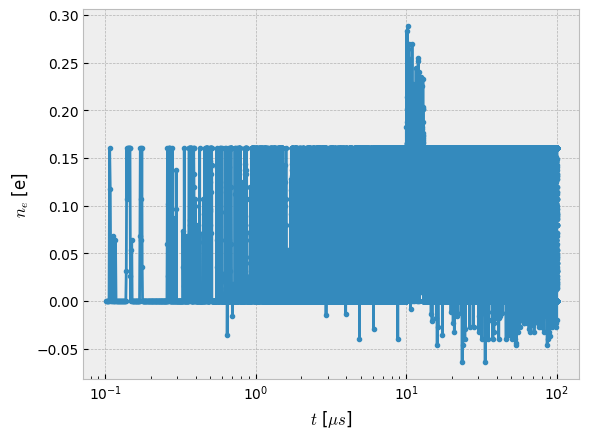

In [134]:
with plt.style.context("bmh"):
    
    plt.plot(time_steps[start_val+1:]*10**6, microstate[:,0], '.-')
    # plt.plot(time_steps[1:]*10**6, microstate[:,-1], '.')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$n_e$ [e]")
    plt.xscale('log')
    plt.show()

#### NP Potential

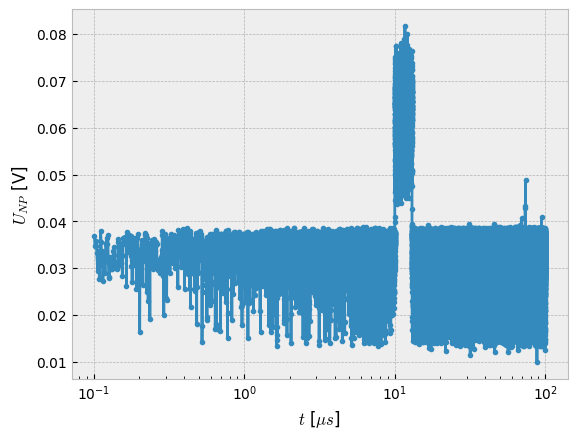

In [135]:
with plt.style.context("bmh"):
    
    plt.plot(time_steps[start_val+1:]*10**6, landscape[:,6], '.-')
    # plt.plot(time_steps[1:]*10**6, microstate[:,-1], '.')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$U_{NP}$ [V]")
    plt.xscale('log')
    plt.show()

#### NP Current

In [136]:
# with plt.style.context("bmh"):
    
#     plt.plot(time_steps[start_val+1:]*10**6, network_I[:,0], '.-')
#     plt.plot(time_steps[start_val+1:]*10**6, network_I[:,18], '.-')
#     # plt.plot(time_steps[1:]*10**6, microstate[:,-1], '.')
#     plt.xlabel("$t$ [$\mu s$]")
#     plt.ylabel("$U_{NP}$ [V]")
#     plt.xscale('log')
#     plt.show()

### Potential evolution

In [137]:
np_index        = 2
potential_evo   = [pot_per_it[i][1:,np_index] for i in stored_indices]
time_evo        = [time_per_it[i][1:] for i in stored_indices]

In [138]:
# def return_auto_c(np_index, pot_per_it, time_per_it, stored_indices, n_lags=100):
    
#     potential_evo   = [pot_per_it[i][1:,np_index] for i in stored_indices]
#     time_evo        = [time_per_it[i][1:] for i in stored_indices]
#     t               = time_evo[t_range] - np.min(time_evo[t_range])
#     arr             = potential_evo[t_range]
#     a_c             = [1. if t==0 else np.corrcoef(arr[:-t],arr[t:])[0,1] for t in range(n_lags)]


In [139]:
n_lags  = 50
t_range = 5
t       = time_evo[t_range] - np.min(time_evo[t_range])
arr     = potential_evo[t_range]
a_c     = [1. if t==0 else np.corrcoef(arr[:-t],arr[t:])[0,1] for t in range(n_lags)]

with plt.style.context("bmh"):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(t*10**9, 1000*potential_evo[t_range], '.-')
    ax1.set_ylabel("$U_{NP}(t)$ [mV]")
    
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(t[:n_lags]*10**9, a_c, '.-')
    ax2.set_ylabel("$corr[U_{NP}(t),U_{NP}(t-1)]$")
    ax2.set_xlabel("$t [ns]$")

    plt.show()

/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/jonas/.local/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


ValueError: x and y must have same first dimension, but have shapes (29,) and (50,)

In [ ]:
jump_paths[6]

(3, 17)

/home/jonas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


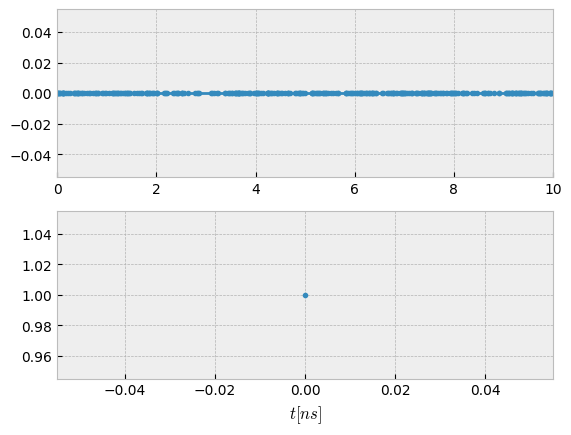

In [ ]:
jump_index      = 6
jumps_per_evo   = [jumps_per_it[i][1:,jump_index] for i in stored_indices]

n_lags  = 200
t_range = 5
t       = time_evo[t_range] - np.min(time_evo[t_range])
arr2    = jumps_per_evo[t_range][1:] - jumps_per_evo[t_range][:-1]
arr2    = np.insert(arr2, 0, 0)
# arr2    = jumps_per_evo[t_range]
a_c_j   = [1. if t==0 else np.corrcoef(arr2[:-t],arr2[t:])[0,1] for t in range(n_lags)]

with plt.style.context("bmh"):
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(t*10**9, arr2, '.-')
    # ax1.set_ylabel("$U_{NP}(t)$ [mV]")
    ax1.set_xlim(0,10)

    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(t[:n_lags]*10**9, a_c_j, '.-')
    # ax2.set_ylabel("$corr[U_{NP}(t),U_{NP}(t-1)]$")
    ax2.set_xlabel("$t [ns]$")

    plt.show()

### Tunneling Evolution

In [ ]:
np_index        = 16
jumps_per_evo   = [jumps_per_it[i][1:,np_index] for i in stored_indices]

In [ ]:
# with plt.style.context("bmh"):
    
#     plt.plot(input_volt[start_val+1:], output_I, '.')
#     plt.xlabel("$U_I$ [V]")
#     plt.ylabel("$I_O$ [nA]")
#     # plt.ylim(-8,8)
#     plt.show()